In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from data_import import (
    load_data, load_ecb_1y_yield,
    fill_liabilities, drop_high_leverage_firms,
    prepare_nig_inputs
)

print(Path.cwd())

c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code


In [2]:
# data import and input panel preparation
ret_daily, bs, coverage = load_data(
    Path.cwd() / "data/raw/Jan2025_Accenture_Dataset_ErasmusCase.xlsx",
    start_date="2012-01-01",
    end_date="2025-12-19",
    enforce_coverage=True,
    coverage_tol=0.95,
    liabilities_scale="auto",
    verbose=True,
)

df_rf = load_ecb_1y_yield(
    startPeriod="2010-01-01",
    endPeriod="2025-12-31",
    out_file="ecb_yc_1y_aaa.xml",
    verify_ssl=True,  # recommended if it works
)

df_cal = ret_daily[["date"]].drop_duplicates().sort_values("date").reset_index(drop=True)

debt_daily = fill_liabilities(bs, df_cal)

ret_filt, bs_filt, lev_by_firm, dropped = drop_high_leverage_firms(
    ret_daily,
    bs,
    df_calendar=df_cal,
    debt_daily=debt_daily,
    lev_threshold=8.0,
    lev_agg="median",
    verbose=True,
)

# keep debt panel consistent with filtered firms
keep = set(ret_filt["gvkey"].astype(str).unique())
debt_daily_filt = debt_daily[debt_daily["gvkey"].astype(str).isin(keep)].copy()

nig_df, em_cache = prepare_nig_inputs(ret_filt, bs_filt, df_rf, debt_daily=debt_daily_filt, build_em=False)
print(nig_df.head())
print(nig_df.shape)
print(nig_df.describe())

[load_data] Firms (ret_daily): 46
[load_data] Date range (ret_daily): 2012-01-03 .. 2025-12-19
[load_data] Coverage min/median/max: 0.999 / 1.000 / 1.000
[load_data] liabilities_scale_used: 1e+06
[load_data] QA mcap_reported<=0 rows (raw windowed mkt): 62
Data has been written to ecb_yc_1y_aaa.xml
[drop_high_leverage_firms] agg=median, threshold=8.0
[drop_high_leverage_firms] firms before: 46 | after: 36
[drop_high_leverage_firms] dropped firms: 10
    gvkey       date             E          isin  \
0  100022 2012-01-03  3.328431e+10  DE0005190003   
1  100080 2012-01-03  4.268705e+10  DE000BAY0017   
2  100312 2012-01-03  1.469717e+09  DE0007030009   
3  100581 2012-01-03  4.935351e+10  FR0000120321   
4  100957 2012-01-03  2.931851e+10  ES0144580Y14   

                        company country_iso         r             L  
0  BAYERISCHE MOTOREN WERKE AKT         DEU  0.001177  8.576700e+10  
1                      BAYER AG         DEU  0.001177  3.254300e+10  
2                RHEINME

### Goal

For each firm/date, solve for \(A_t\) in:

$$
E_t = C_{\text{NIG}}(A_t, L_t, r_t, \tau; \vartheta_A),
\qquad
\tau = T - t
$$

where \(C_{\text{NIG}}\) is the NIG‑based equity‑as‑call valuation used by Ahčan & Jovan (Eq. 26).

### Outputs

**Daily asset values**

$$
\hat{A}_t
$$

**Asset log returns**

$$
\Delta \ln \hat{A}_t
$$

#### NIG Components

**NIG log‑mgf**

$$
\kappa(u)
$$

**Esscher parameter \(\theta\)**  
Solving the martingale condition (risk‑neutralization)

$$
\theta \text{ such that the RN drift condition holds}
$$

**NIG call price**

$$
C_{\text{NIG}}(A, L, r, \tau)
$$

via a robust Fourier probability representation.

**Asset inversion**

$$
E \;\longmapsto\; \hat{A}
$$

via Brent root finding (same spirit as the paper’s “uniroot” step).



In [3]:
import numpy as np
from dataclasses import dataclass
from scipy.optimize import brentq
from scipy.integrate import quad

@dataclass(frozen=True)
class NIGParams:
    # NIG for log-returns Z: (alpha, beta, delta, mu) under P, per unit time
    alpha: float
    beta: float
    delta: float
    mu: float

    def validate(self):
        if not (self.alpha > abs(self.beta)):
            raise ValueError("Need alpha > |beta| for NIG.")
        if not (self.delta > 0):
            raise ValueError("Need delta > 0 for NIG.")

In [8]:
def nig_kappa(u, p: NIGParams, tau: float):
    """
    Vectorized log-mgf kappa(u; tau) for NIG increments.
    u can be scalar or numpy array (real/complex).
    """
    p.validate()
    a, b, d, m = p.alpha, p.beta, p.delta, p.mu

    u = np.asarray(u, dtype=np.complex128)

    term0 = np.sqrt(a*a - b*b)
    term1 = np.sqrt(a*a - (b + u)*(b + u))
    return (m * u + d * (term0 - term1)) * tau


def solve_esscher_theta(p: NIGParams, r: float, tau: float, *, bracket=(-10.0, 10.0)) -> float:
    """
    Solve for theta in:
      kappa(theta+1) - kappa(theta) = r*tau
    """
    lo, hi = bracket

    def g(th):
        # th is real
        return (nig_kappa(th + 1.0, p, tau) - nig_kappa(th, p, tau)).real - (r * tau)

    # ensure bracket contains root; expand if needed
    f_lo, f_hi = g(lo), g(hi)
    tries = 0
    while f_lo * f_hi > 0 and tries < 10:
        lo *= 2
        hi *= 2
        f_lo, f_hi = g(lo), g(hi)
        tries += 1

    if f_lo * f_hi > 0:
        raise RuntimeError("Could not bracket theta root; try different initial NIG params or bracket.")

    return float(brentq(g, lo, hi, maxiter=200))


def cf_logA_T_vec(u, lnA: float, p: NIGParams, theta: float, tau: float):
    """
    Vectorized characteristic function of ln A_T under Esscher tilt theta.
    u can be scalar or numpy array (real/complex).
    """
    u = np.asarray(u, dtype=np.complex128)
    iu = 1j * u
    psi = nig_kappa(theta + iu, p, tau) - nig_kappa(theta, p, tau)
    return np.exp(1j * u * lnA + psi)


def _Pj_prob(
    j: int,
    A: float,
    K: float,
    p: NIGParams,
    theta: float,
    tau: float,
    *,
    U: float = 120.0,
    n: int = 8000,
    eta: float = 1.0,
) -> float:
    if j not in (1, 2):
        raise ValueError("j must be 1 or 2")
    if A <= 0 or K <= 0 or tau <= 0:
        return np.nan

    lnA = float(np.log(A))
    lnK = float(np.log(K))

    # real u-grid
    u = np.linspace(1e-8, U, n)

    # shift for P1: use phi(u - i); for P2: use phi(u)
    shift = -1j * (j - 1)  # 0 for P2, -i for P1
    u_shifted = u + shift

    # phi(u - i*(j-1))
    phi = cf_logA_T_vec(u_shifted, lnA, p, theta, tau)

    # normalizer phi(-i*(j-1))
    u0 = shift
    phi_shift = cf_logA_T_vec(u0, lnA, p, theta, tau)  # scalar complex

    # complex integrand core: exp(-i u lnK) * phi(...) / (i u phi_shift)
    expo = np.exp(-1j * u * lnK)
    q = expo * phi / (1j * u * phi_shift)

    # damping (stabilizes tail)
    integrand = np.real(q) * np.exp(-eta * u)

    integral = np.trapezoid(integrand, u)
    Pj = 0.5 + (1.0 / np.pi) * integral
    return float(np.clip(Pj, 0.0, 1.0))


def call_nig_with_theta(
    A: float, K: float, r: float, tau: float, p: NIGParams, theta: float,
    *, U: float = 120.0, n: int = 8000, eta: float = 1.0
) -> float:
    P1 = _Pj_prob(1, A, K, p, theta, tau, U=U, n=n, eta=eta)
    P2 = _Pj_prob(2, A, K, p, theta, tau, U=U, n=n, eta=eta)
    return A * P1 - K * np.exp(-r * tau) * P2


def invert_asset_one_date(
    E_obs, L, r, tau, p,
    *, A_prev=None, U=120.0, n=8000, eta=1.0, bracket_mult=5.0
):
    theta = solve_esscher_theta(p, r, tau)

    A0 = max(E_obs + 1e-12, E_obs + L, (A_prev if A_prev is not None else 0.0))
    A_lo = max(E_obs + 1e-12, 1e-12)
    A_hi = max(A0, E_obs + bracket_mult * L)

    def f(A):
        return call_nig_with_theta(A, L, r, tau, p, theta, U=U, n=n, eta=eta) - E_obs

    f_lo, f_hi = f(A_lo), f(A_hi)
    tries = 0
    while f_lo * f_hi > 0 and tries < 20:
        A_hi *= 2.0
        f_hi = f(A_hi)
        tries += 1
    if f_lo * f_hi > 0:
        raise RuntimeError("Could not bracket root for A.")

    A_hat = float(brentq(f, A_lo, A_hi, maxiter=200))
    return A_hat, theta

In [9]:
# Pick BMW
gv = "100022"
g = nig_df[nig_df["gvkey"].astype(str) == gv].sort_values("date").copy()

# pick one month-end date (last date of a month available in your trading calendar)
g["month"] = g["date"].dt.to_period("M")
month_ends = g.groupby("month")["date"].max().sort_values()
asof = month_ends.iloc[0]  # earliest month-end in sample (change as you like)

row = g[g["date"] == asof].iloc[0]
E_obs, L, r = float(row["E"]), float(row["L"]), float(row["r"])
tau = 1.0  # 1Y horizon in years (you can later use ACT/365 convention, but 1.0 is fine for Milestone 1)

# Starter NIG parameters (placeholder, just for Milestone 1 stability)
# Must satisfy alpha > |beta| and delta > 0.
p0 = NIGParams(alpha=15.0, beta=-3.0, delta=0.20, mu=0.00)

A_hat, theta = invert_asset_one_date(E_obs, L, r, tau, p0, U=150.0, eta=1.0)
print("Date:", asof.date())
print("E_obs:", E_obs)
print("L:", L)
print("r:", r)
print("A_hat:", A_hat)
print(call_nig_with_theta(A_hat, L, r, tau, p0, theta))



Date: 2012-01-31
E_obs: 39364465866.44
L: 85767000000.0
r: 0.0020614851688972656
A_hat: 146251321043.61948
39364361927.3826


We now have, for a single date:

$$
E_t \;\longrightarrow\; \hat{A}_t
$$

We will now extend this to a full time series:

$$
\{E_t\}_{t \in \text{month-ends}}
\;\longrightarrow\;
\{\hat{A}_t\}_{t \in \text{month-ends}}
\;\longrightarrow\;
\Delta \ln \hat{A}_t
$$

#### Outputs

- **Monthly asset levels**

$$
\{\hat{A}_t\}_{t \in \text{month-ends}}
$$

- **Monthly asset log‑returns**

$$
\Delta \ln \hat{A}_t
$$


In [6]:
def invert_assets_monthly_for_firm(
    g: pd.DataFrame,
    p: NIGParams,
    tau: float = 1.0,
    U: float = 150.0,
    eta: float = 1.0,
):
    g = g.sort_values("date").copy()
    g["month"] = g["date"].dt.to_period("M")
    month_ends = g.groupby("month")["date"].max().sort_values()

    results = []
    A_prev = None

    for d in month_ends:
        row = g[g["date"] == d].iloc[0]
        E_obs = float(row["E"])
        L     = float(row["L"])
        r     = float(row["r"])

        # unpack two outputs
        A_hat, theta = invert_asset_one_date(
            E_obs, L, r, tau, p,
            A_prev=A_prev,
            U=U,
            eta=eta
        )

        results.append((d, E_obs, L, r, A_hat, theta))
        A_prev = A_hat

    out = pd.DataFrame(results, columns=["date", "E", "L", "r", "A_hat", "theta"])
    out["logA"] = np.log(out["A_hat"])
    out["logret_A"] = out["logA"].diff()
    return out

In [7]:
gv = "100022"
g = nig_df[nig_df["gvkey"].astype(str) == gv].copy()

p0 = NIGParams(alpha=15.0, beta=-3.0, delta=0.20, mu=0.00)

import time
start = time.time()

bmw_assets = invert_assets_monthly_for_firm(g, p0, U=120.0, eta=1.0)

print("Runtime:", time.time() - start)
print(bmw_assets.head())

KeyboardInterrupt: 

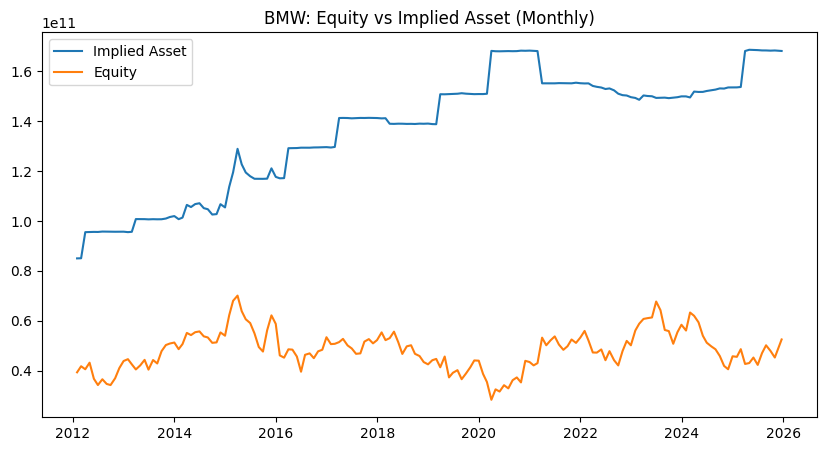

count    167.000000
mean       0.004083
std        0.023117
min       -0.080004
25%       -0.000666
50%        0.000053
75%        0.000798
max        0.115972
Name: logret_A, dtype: float64


In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(bmw_assets["date"], bmw_assets["A_hat"], label="Implied Asset")
plt.plot(bmw_assets["date"], bmw_assets["E"], label="Equity")
plt.legend()
plt.title("BMW: Equity vs Implied Asset (Monthly)")
plt.show()

print(bmw_assets["logret_A"].describe())